In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())

Train Data:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Test Data:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiw

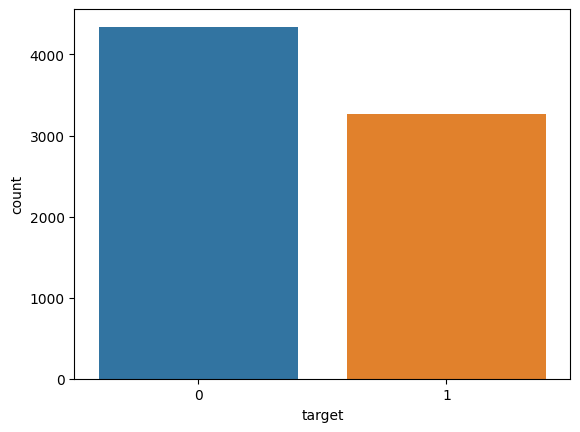

In [12]:
sns.countplot(x='target', data=train_df)
plt.show()

In [13]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(words)

train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

In [14]:
from gensim.utils import simple_preprocess

tokenized_text = [simple_preprocess(text) for text in train_df['processed_text']]

word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

word2vec_model.save("word2vec_model")


In [15]:
def get_word_embedding(text):
    embedding = np.zeros(100)
    count = 0
    for word in text.split():
        if word in word2vec_model.wv:
            embedding += word2vec_model.wv[word]
            count += 1
    if count != 0:
        embedding /= count
    return embedding

train_df['word_embedding'] = train_df['processed_text'].apply(get_word_embedding)
test_df['word_embedding'] = test_df['processed_text'].apply(get_word_embedding)


In [16]:

X = np.array(train_df['word_embedding'].to_list())
y = np.array(train_df['target'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)



LogisticRegression(random_state=42)

In [17]:

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)


Model Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.84      0.71       874
           1       0.56      0.27      0.37       649

    accuracy                           0.60      1523
   macro avg       0.59      0.56      0.54      1523
weighted avg       0.59      0.60      0.56      1523



In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['processed_text'])

sequences = tokenizer.texts_to_sequences(train_df['processed_text'])
X_seq = pad_sequences(sequences, maxlen=50)  

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_seq, y, test_size=0.2, random_state=42)

model_seq = Sequential()
model_seq.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=50))
model_seq.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_seq.add(Dense(1, activation='sigmoid'))

model_seq.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_seq.fit(X_train_seq, y_train_seq, epochs=5, batch_size=32, validation_data=(X_val_seq, y_val_seq))


Epoch 1/5
191/191 [==============================] - 20s 87ms/step - loss: 0.5484 - accuracy: 0.7158 - val_loss: 0.4479 - val_accuracy: 0.7945
Epoch 2/5
191/191 [==============================] - 16s 83ms/step - loss: 0.2966 - accuracy: 0.8775 - val_loss: 0.4922 - val_accuracy: 0.7735
Epoch 3/5
191/191 [==============================] - 16s 84ms/step - loss: 0.1692 - accuracy: 0.9374 - val_loss: 0.5963 - val_accuracy: 0.7623
Epoch 4/5
191/191 [==============================] - 16s 82ms/step - loss: 0.1119 - accuracy: 0.9624 - val_loss: 0.7114 - val_accuracy: 0.7564
Epoch 5/5
191/191 [==============================] - 16s 84ms/step - loss: 0.0828 - accuracy: 0.9736 - val_loss: 0.7176 - val_accuracy: 0.7505


In [19]:

sequences_test = tokenizer.texts_to_sequences(test_df['processed_text'])
X_test_seq = pad_sequences(sequences_test, maxlen=50)

loss, accuracy = model_seq.evaluate(X_val_seq, y_val_seq)
print(f"Sequential Model Accuracy on Validation Set: {accuracy:.2f}")

48/48 [==============================] - 1s 13ms/step - loss: 0.7176 - accuracy: 0.7505
Sequential Model Accuracy on Validation Set: 0.75


In [20]:
test_predictions_seq = (model_seq.predict(X_test_seq) > 0.5).astype("int32")

102/102 [==============================] - 2s 12ms/step


In [21]:
submission_df_seq = pd.DataFrame({'id': test_df['id'], 'target': test_predictions_seq.flatten()})

submission_df_seq.to_csv("submission_seq.csv", index=False)

